In [1]:
# fastai 0.7.2
!pip install git+https://github.com/fastai/fastai@e85667cfae2e6873b1bb026195b5d09a74dfcff9
%load_ext autoreload
%autoreload 2

%matplotlib inline

  Cloning https://github.com/fastai/fastai (to revision e85667cfae2e6873b1bb026195b5d09a74dfcff9) to /tmp/pip-req-build-m3h1can_
    100% |████████████████████████████████| 496.4MB 71kB/s  eta 0:00:01    75% |████████████████████████        | 373.0MB 75.1MB/s eta 0:00:02


  Stored in directory: /tmp/pip-ephem-wheel-cache-__ylatn2/wheels/45/27/d3/efc22827a5cfab07661c0a112b73d41001257f998e970dcd9b
Successfully built fastai
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Found existing installation: fastai 1.0.50.post1
    Uninstalling fastai-1.0.50.post1:
      Successfully uninstalled fastai-1.0.50.post1


In [2]:
from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

from tqdm import tqdm

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.precision", 15): 
        display(df)

In [4]:
path = Path("../input")

In [5]:
train_df = pd.read_csv(path/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

# Data from air
From https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [6]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))

In [7]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [8]:
import warnings
from scipy import stats
from scipy.signal import hann
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [9]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [10]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [11]:
for seg_id in tqdm(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

100%|██████████| 4194/4194 [25:06<00:00,  2.84it/s]


In [12]:
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [13]:
for seg_id in tqdm(test_X.index):
    seg = pd.read_csv(path/f'test/{seg_id}.csv')
    create_features(seg_id, seg, test_X)

100%|██████████| 2624/2624 [17:19<00:00,  2.49it/s]


In [14]:
test_X.reset_index(inplace=True)

In [15]:
test_df = test_X

In [16]:
df = pd.concat([train_X, train_y], axis=1); df.shape

(4194, 148)

# Make it stupid

In [17]:
def print_score(m):
    res = [metrics.mean_absolute_error(m.predict(X_train), y_train), metrics.mean_absolute_error(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [18]:
df_trn, y_trn, nas = proc_df(df, 'time_to_failure')

In [19]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()
    
train_required_ratio = 0.80
n_trn = int(len(df_trn) * train_required_ratio)

X_train, X_valid = split_vals(df_trn, n_trn)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape

((3355, 147), (839, 147))

In [20]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.749212389127233, 2.5554441703371618, 0.9269022387556956, 0.3456851469462269]


In [21]:
X_train = df_trn.copy()
X_train.drop(df_trn.loc[100:349].index, inplace=True)
X_valid = df_trn.iloc[100:350]

y_train = np.concatenate([y_trn[:100], y_trn[350:]])
y_valid = y_trn[100:350]

# y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape, len(y_train), len(y_valid)

((3944, 147), (250, 147), 3944, 250)

In [22]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.7853756018552569, 1.7733821842880615, 0.9245729553813196, 0.5569387801406146]


In [23]:
# preds = np.stack([t.predict(X_valid) for t in m.estimators_])
# preds[:,0], np.mean(preds[:,0]), y_valid[0]

In [24]:
# plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

In [25]:
set_rf_samples(50_000)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2810106675566052, 1.7744406944204152, 0.9841244894136691, 0.5518299638963496, -2.405488197037503]


In [27]:
reset_rf_samples()

# Final model

In [28]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.839800563331672, 1.7502792543643095, 0.909006402022312, 0.5662550091496776, 0.45755602299496234]


In [29]:
fi = rf_feat_importance(m, df_trn)

In [30]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

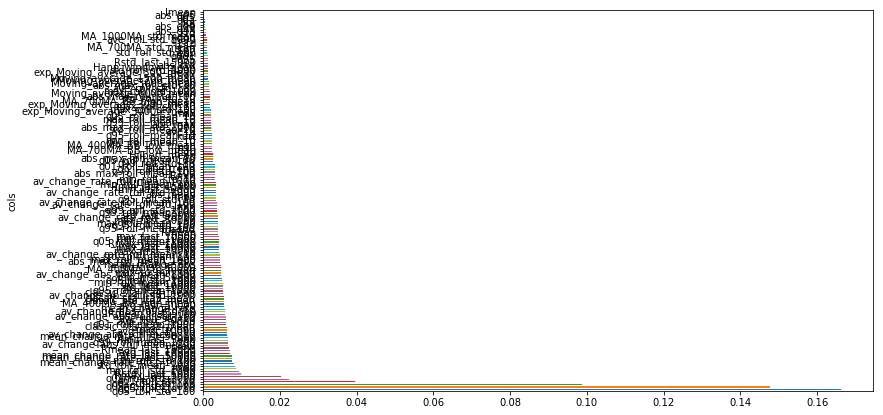

In [31]:
plot_fi(fi);

In [43]:
important = fi[fi.imp>0.005]

In [45]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

43

In [46]:
X_train = df_trn[to_keep].copy()
X_train.drop(df_trn[to_keep].loc[100:349].index, inplace=True)
X_valid = df_trn[to_keep].iloc[100:350]

y_train = np.concatenate([y_trn[:100], y_trn[350:]])
y_valid = y_trn[100:350]

# y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape, len(y_train), len(y_valid)

((3944, 43), (250, 43), 3944, 250)

In [47]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8610105500886865, 1.7442663437965715, 0.9031323227504834, 0.5596976383066945, 0.4584106000805589]


In [50]:
preds = m.predict(test_df[to_keep])

In [58]:
# preds = m.predict(test_df.drop(columns="seg_id"))

In [51]:
subm_df = pd.DataFrame(test_df["seg_id"])

In [52]:
subm_df["time_to_failure"] = preds

In [53]:
subm_df.head()

,seg_id,time_to_failure
0,seg_00030f,3.307157
1,seg_0012b5,5.914957
2,seg_00184e,4.967985
3,seg_003339,8.085365
4,seg_0042cc,6.726980


In [54]:
subm_df.to_csv('submission.csv', index=False)